Iota Calculation, Fourier Surface Extraction, and Perturbations (Wendelstein 7-X)
=================================================================================

This example shows how to calculate the rotational transform for Wendelstein 7-X. 

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import importlib
importlib.reload(fsc.magnetics)
importlib.reload(fsc.flt)

<module 'fusionsc.flt' from 'C:\\Daten\\repos\\fsc\\src\\python\\fusionsc\\flt.py'>

First, we need to perform some setup to make sure W7-X data are available.

Note: The W7-X geometry is currently protected by the W7-X data access agreement. Therefore, the file referenced below is available to W7-X team members (including external collaborators who signed this agreement) upon request.

In [3]:
fsc.resolve.importOfflineData('../../w7x-op21.fsc')

Now we need to setup the geometry and magnetic field configuration. To speed up the magnetic field calculation, we use a slightly coarser grid.

In [4]:
field = w7x.standard()

grid = w7x.defaultGrid()
grid.nR = 32
grid.nZ = 32
grid.nPhi = 32

field = field.compute(grid)
await field

C:\Daten\repos\fsc\src\python\fusionsc\wrappers.py:144: UserWarning: The function fusionsc.devices.w7x.defaultGrid is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.
  warnings.warn(f"The function {f.__module__}.{f.__qualname__} is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.")


Finally, we need to decide in which phi planes we want to evaluate our iota and start our surfaces from.

In [5]:
xStart = np.linspace(5.65, 6.3, 30)
yStart = 0 * xStart
zStart = 0 * xStart

Now it's time to run our calculation.

In [6]:
iotas = fsc.flt.calculateIota(
    field, [xStart, yStart, zStart],
    200, # Turn count
    unwrapEvery = 10, distanceLimit = 1e4, 
    targetError = 1e-3, minStepSize = 1e-3
)

The iota profile is returned in a shape matching the start point shape, and can be easily plotted.

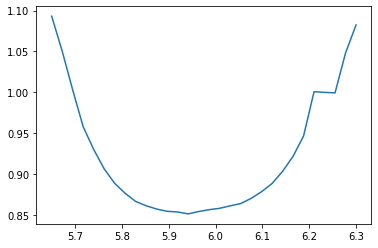

In [7]:
plt.plot(xStart, iotas)

Additionally, the field line tracer can also extract the Fourier decomposition of the magnetic surfaces from the field line. 

In [ ]:
modes = fsc.flt.calculateFourierModes(
    field, [xStart, yStart, zStart],
    200, # Turn count
    nMax = 5, mMax = 5, toroidalSymmetry = 5,
    unwrapEvery = 10, recordEvery = 10,
    targetError = 1e-3, distanceLimit = 1e5,
    stellaratorSymmetric = True
)

The modes are returned with a dict containing rotational transform and the Fourier expansion of the modes, as well as an encoding of the result as a FourierSurfaces object that can also be used in VMEC inputs.

In [ ]:
modes.keys()

Of particular interest are two components: The first one is the 'iota' array, which returns the rotational transforms.

In [ ]:
modes["iota"]

Secondarily relevant is the 'surfaces' element, which contains the magnetic surfaces. This is an instance of the class fusionsc.magnetics.SurfaceArray, which can be sliced, added, and multiplied similar to a regular NumPy array.

In [ ]:
surfaces = modes["surfaces"]

print(type(surfaces))
print("First:\n", surfaces[0])
print("Last:\n", surfaces[-1])
print("Average:\n", (surfaces[0] + surfaces[-1]) / 2)

In [ ]:
modes["theta"]

To plot the modes, we need to multiply the Fourier coefficients with the appropriate angles.

In [ ]:
iSurf = 0
thetas = np.linspace(0, 2 * np.pi, 100)
phis = np.linspace(0, 2 * np.pi / 10, 3)

data = surfaces.evaluate(phis, thetas) # Surfaces -5, -4, -3 are rational and failed to reconstruct

print(data['points'].shape)

for iPhi in range(len(phis)):
    plt.figure()
    for iSurf in range(0, min(data['points'].shape[1], 10)):
        dp = 1
        x, y, z = data['points'][:,iSurf,iPhi,::dp]
        dx, dy, dz = data['thetaDerivatives'][:,iSurf,iPhi,::dp]
        
        r = np.sqrt(x**2 + y**2)
        
        dr = (dx * x + dy * y) / r
        
        
        plt.plot(r, z)
        #plt.quiver(r, z, dr, dz)
    plt.axis('equal')
    plt.xlim(4, 7)
    plt.ylim(-1.5, 1.5)
plt.show()
"""
for iPhi in range(len(phis)):
    plt.figure()
    for iSurf in range(0, data['points'].shape[1]):
        dp = 5
        x, y, z = data['points'][:,iSurf,iPhi,::dp]
        dx, dy, dz = data['phiDerivatives'][:,iSurf,iPhi,::dp]
        
        r = np.sqrt(x**2 + y**2)
        
        dr = (dx * x + dy * y) / r
        
        
        #plt.plot(r, z)
        plt.quiver(x, y, dx, dy)
    plt.axis('equal')
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
plt.show()"""
""

The obtained surfaces can also be used to calculate a mode decomposition of the magnetic field

In [ ]:
surf = surfaces[6]
#np.asarray(surf.data.rCos)[0,0] += 0.03

modes = field.calculateRadialModes(surf, field, nSym = 5, mMax = 10, nMax = 10, nTheta = 250, nPhi = 250)
cc = modes["cosCoeffs"]
sc = modes["sinCoeffs"]

m = modes["mPol"]
n = modes["nTor"]

phi = modes["phi"]
theta = modes["theta"]

tot = np.sqrt(cc**2 + sc**2)

plt.figure(figsize=(16,9))
plt.imshow(modes["radialValues"], origin='lower')
plt.colorbar()
plt.title("Brad / B")

plt.figure(figsize=(16,9))
plt.imshow(tot.T, origin = "lower", norm = "log")
#plt.xlabel(f"n[0, {n[1]:.0f} ... {max(n):.0f}, {min(n):.0f}, ..., {n[-1]:.0f}]")
plt.xlabel("n")
plt.ylabel("m")
plt.xticks(range(len(n)), n)
plt.title("Fourier components of Brad / B")
plt.colorbar()
plt.show()

print(modes["radialValues"].shape)
for i_m, mVal in enumerate(m):
    for i_n, nVal in enumerate(n):
        if mVal > 5: continue
        if nVal < 0: continue
        if nVal > 10: continue
        print(f"n = {nVal:.0f}, m = {mVal:.0f}, val = {tot[i_n][i_m]:.2e}")
